In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer,  MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from kmodes.kprototypes import KPrototypes
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator
from sklearn.decomposition import PCA


from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

frTRAIN = 0.8               # % size of training dataset
RNDN = 42                   # random state
nK = 12                     # initial guess: clusters


In [2]:
df= pd.read_csv('../data/processed/processed_data.csv')
pd.set_option('display.max_columns', 51)

In [3]:
CATEGORICAL_COLUMNS= ['ext_allowed', 'parking_type', 'accessible', 'ev_charging', 'heated', 'rooftop_exposed',
       'has_monthly_rates', 'has_transient_rates','scan_to_pay_flag', 'iq_facility','covered_parking', 'inout_allowed','has_event_rates', 'on_site_staff','facility_type_under_el', 'facility_type_garage',
       'facility_type_valet_stand', 'facility_type_lot',
       'facility_type_personal_spot','average_star_rating']
DEMOCRATIC_COLUMNS = ['facility_id', 'reporting_neighborhood']
NUMERICAL_COLUMNS = [[col for col in df.columns if (col not in DEMOCRATIC_COLUMNS) and (col not in CATEGORICAL_COLUMNS)]]

In [4]:
'''
We will use Principal Feature Analysis to extract important features as they are of mixed types.
It uses PCA and K-means
'''
class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = MinMaxScaler()
        
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [5]:
def get_PFA_Features(df,n_features):
    
    pfa = PFA(n_features)
    pfa.fit(df.iloc[:,1::])

    # To get the transformed matrix
    X = pfa.features_

    # To get the column indices of the kept features
    column_indices = pfa.indices_
    
    #column indices dictionary with keys as indices and values as column names
    column_dict = {i: col for i, col in enumerate(df.columns[1:])}
    
    #Columns selected by PFA
    column_names_to_keep = [column_dict[ind] for ind in column_indices]
    
    return column_names_to_keep

In [6]:
column_names_to_keep=get_PFA_Features(df, 25)

In [7]:
# Helper function to assist in getting elbow point from sse scores that is ususally done manually in production with visualization
def knee_locator(sse):
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    return kl.elbow+1


# Getting elbow point
def get_elbow_point(df,column_names_to_keep):
    # defining new dataframe with selected features
    df_new = df[column_names_to_keep]
    
    # converting categorical column names to indexes
    column_dict = {col: i for i, col in enumerate(column_names_to_keep)}
    
    # calculating inertia scores
    sse=[]
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df_new)
        sse.append(kmeans.inertia_)


    # Finding Elbow Point    
    elbow_point = knee_locator(sse)
    return elbow_point
        
        

In [8]:
get_elbow_point(df,column_names_to_keep)

4

In [9]:
# elbow score plot with Yellowbrick
def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  

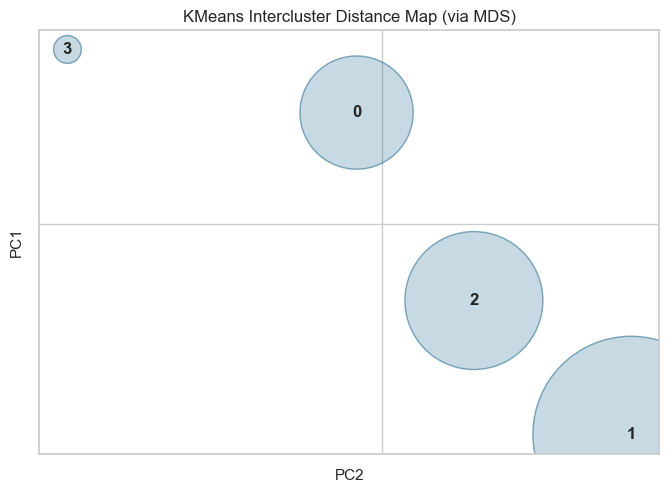

In [17]:
# optimal number of clusters: intercluster distances
model = KMeans(
    n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
visD = InterclusterDistance(
    model, max_size=20000, legend=False, random_state=RNDN)
visD.fit(df)
visD.finalize()

Hence it is evident that we can work with four clusters

Hence from above diagram, I see that 4 well separated clusters can be obtained.

In [18]:
# %split training vs test dataset
df_train, df_test = train_test_split(df, train_size=frTRAIN, random_state=RNDN)

K = 4
# training: generate "Cluster" column based on optimal number of clusters
model = KMeans(n_clusters=K, random_state=RNDN)
res = model.fit_predict(df_train)
df_train.insert(0, "Cluster", res)     # insert cluster labels as new column
df_train.tail()

,Cluster,facility_id,reporting_neighborhood,height_restriction,ext_allowed,parking_type,accessible,ev_charging,heated,rooftop_exposed,has_monthly_rates,has_transient_rates,p4w_total_gross_revenue,p4w_new_drivers,num_words_parking_instruction,p4w_sipp,user_issues_per_park,tipp,product_cpp,total_cpp,p4w_lot_full,num_stalls,rental_count,p4w_return_pct,scan_to_pay_flag,iq_facility,customer_reviews_count,covered_parking,inout_allowed,utilization,has_event_rates,searches,on_site_staff,facility_type_under_el,facility_type_garage,facility_type_valet_stand,facility_type_lot,facility_type_personal_spot,refund_pct,average_star_rating
71,1,72,25,180.0,1,2,1,0,0,0,0,1,3609.0,152.0,64.0,6.042,0.0,0.0,667.0,1000.0,1.0,10.0,4266.0,0.240,0,0,1152.0,0,1,0.3541,0,37835.0,0,0,0,0,1,0,0.0255,4
106,1,107,36,74.0,1,0,1,0,0,0,0,1,1464.5,76.0,34.0,9.346,0.0,43.0,174.0,1087.0,1.0,1.0,4079.0,0.191,0,1,1006.0,0,0,0.2923,0,32937.0,0,0,0,0,1,0,0.0413,4
270,1,271,9,180.0,1,0,1,0,0,0,0,1,251.5,20.0,76.0,37.037,500.0,0.0,0.0,1000.0,0.0,1.0,462.0,0.130,1,1,172.0,0,1,0.2722,0,900.0,1,0,0,0,1,0,0.0400,4
435,1,436,47,180.0,1,0,0,0,0,0,0,1,255.2,8.0,91.0,0.000,0.0,0.0,500.0,1000.0,0.0,1.0,180.0,0.111,0,0,28.0,0,1,0.1576,1,2523.0,0,0,0,0,0,1,0.0000,4
102,1,103,20,180.0,1,0,0,0,0,0,0,1,285.0,38.0,181.0,12.346,333.0,0.0,0.0,1000.0,0.0,3.0,1491.0,0.191,0,0,531.0,0,1,0.4046,1,1223.0,0,1,0,0,0,0,0.0548,3


In [19]:
# training: get silhouette score
sil_train = silhouette_score(df_train, res)
print("training: silhouette score for", f'{K:.0f} clusters: {sil_train:.3f}')

training: silhouette score for 4 clusters: 0.689


In [20]:
# testing: generate "Cluster" column based on optimal number of clusters
pred = model.fit_predict(df_test)
sil_test = silhouette_score(df_test, pred)
print("testing: silhouette score for", \
    f'{K:.0f} clusters: {sil_test:.3f}. Variance vs training: {(sil_test / sil_train -1)*100:.1f}%')
df_test.insert(0, "Cluster", pred)  

testing: silhouette score for 4 clusters: 0.683. Variance vs training: -0.9%


In [21]:
# insert Cluster column in original dataframe
df["Cluster"] = pd.concat([df_train["Cluster"], df_test["Cluster"]], axis=0)
df = df.sort_values("Cluster")

# size of clusters
dfgrp = df.groupby("Cluster").count()
dfgrp.facility_id

Cluster
0    198
1    395
2     42
3     59
Name: facility_id, dtype: int64

## Cluster Profiling

In [22]:
column_names_to_keep

['reporting_neighborhood',
 'has_monthly_rates',
 'parking_type',
 'iq_facility',
 'inout_allowed',
 'heated',
 'rooftop_exposed',
 'has_transient_rates',
 'p4w_total_gross_revenue',
 'customer_reviews_count',
 'refund_pct',
 'facility_type_lot',
 'product_cpp',
 'total_cpp',
 'num_stalls',
 'rental_count',
 'covered_parking',
 'utilization',
 'searches',
 'on_site_staff',
 'facility_type_under_el',
 'facility_type_garage',
 'facility_type_valet_stand',
 'facility_type_personal_spot',
 'average_star_rating']

In [30]:
# helper function: pie charts for categorical variables
def cluster_pies(df):
    
    # number of categorical variables
    c = len(CATEGORICAL_COLUMNS)
    print(c)
    
    # number of clusters
    K = df["Cluster"].nunique()

    for k in tqdm(range(K)):
        dfc = df[df["Cluster"]==k]
        revenue = dfc["p4w_total_gross_revenue"].median()
        repeat_driver_prc = dfc["p4w_return_pct"].median()
        height_restr = dfc['height_restriction'].median()
#         searches=dfc['p4w_new_drivers'].median()
        words_in_facility_instruction = dfc['num_words_parking_instruction'].median()
        supply_issues = dfc['p4w_sipp'].median()
        tech_issues = dfc['tipp'].median()
        total_cpp = dfc['total_cpp'].median()
        costs_for_product_issue = dfc['product_cpp'].median()
        total_costs = dfc['total_cpp'].median()
        lot_full_incidents = dfc['p4w_lot_full'].median()
        spot_hero_stalls = dfc['num_stalls'].median()
        facility_rented_count = dfc['rental_count'].median()
        utilization_ratio = dfc['utilization'].median()
        searches = dfc.searches.median()
        rentals_refunded = dfc['refund_pct'].median()
        
        cases = df.shape[0]

        fig = plt.figure(figsize=(50, 15))
        fig.suptitle( "Cluster " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases | " + \
            "P4W total gross revenue  " + f'{revenue:.2f}' + \
            " | repeat drivers " + f'{repeat_driver_prc:.2f}' +\
            " |  Stalls owned by SpotHero"+f'{spot_hero_stalls:.0f}')
        


        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["ext_allowed"].value_counts(), labels=dfc["ext_allowed"].unique())
        plt.title("Extension Allowed at Facility");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["parking_type"].value_counts(), labels=dfc["parking_type"].unique())
        plt.title("Parking Type");


        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["heated"].value_counts(), labels=dfc["heated"].unique())
        plt.title("Facility Heated");

        ax1 = plt.subplot2grid((2,c),(0,3))
        plt.pie(dfc["rooftop_exposed"].value_counts(), labels=dfc["rooftop_exposed"].unique())
        plt.title("Rooftop Exposed");

        ax1 = plt.subplot2grid((2,c),(0,4))
        plt.pie(dfc["has_monthly_rates"].value_counts(), labels=dfc["has_monthly_rates"].unique())
        plt.title("Monthly Reservation Provided")
        
        ax1 = plt.subplot2grid((2,c),(0,5))
        plt.pie(dfc["has_transient_rates"].value_counts(), labels=dfc["has_transient_rates"].unique())
        plt.title("Transient Reservation Provided")
        
        
        ax1 = plt.subplot2grid((2,c),(0,6))
        plt.pie(dfc["iq_facility"].value_counts(), labels=dfc["iq_facility"].unique())
        plt.title("Dynamic Rates Posted")
        
        ax1 = plt.subplot2grid((2,c),(0,7))
        plt.pie(dfc["covered_parking"].value_counts(), labels=dfc["covered_parking"].unique())
        plt.title("Facility Covered")
        
       
        ax1 = plt.subplot2grid((2,c),(0,8))
        plt.pie(dfc["inout_allowed"].value_counts(), labels=dfc["inout_allowed"].unique())
        plt.title("In/Out Allowed during Reservation")
        
        
        ax1 = plt.subplot2grid((2,c),(0,9))
        plt.pie(dfc["on_site_staff"].value_counts(), labels=dfc["on_site_staff"].unique())
        plt.title("On-Site Staff Available")
        
        ax1 = plt.subplot2grid((2,c),(0,10))
        plt.pie(dfc["facility_type_under_el"].value_counts(), labels=dfc["facility_type_under_el"].unique())
        plt.title("Underground Type Facility")
        
        ax1 = plt.subplot2grid((2,c),(0,11))
        plt.pie(dfc["facility_type_garage"].value_counts(), labels=dfc["facility_type_garage"].unique())
        plt.title("Garage Type Facility")
        
        ax1 = plt.subplot2grid((2,c),(0,12))
        plt.pie(dfc["facility_type_valet_stand"].value_counts(), labels=dfc["facility_type_valet_stand"].unique())
        plt.title("Valet Available")
        
        
        ax1 = plt.subplot2grid((2,c),(0,13))
        plt.pie(dfc["facility_type_lot"].value_counts(), labels=dfc["facility_type_lot"].unique())
        plt.title("OpenLot Facility")
        
        ax1 = plt.subplot2grid((2,c),(0,14))
        plt.pie(dfc["facility_type_personal_spot"].value_counts(), labels=dfc["facility_type_personal_spot"].unique())
        plt.title("Personal Parking Spot")
        
        ax1 = plt.subplot2grid((2,c),(0,15))
        plt.pie(dfc["average_star_rating"].value_counts(), labels=dfc["average_star_rating"].unique())
        plt.title("Customer Rating")
        

In [31]:
# helper function: medians and modes for each cluster
def cluster_profile(df):
    dfc = df.groupby("Cluster").agg({ 
        "height_restriction": "median",
        "p4w_total_gross_revenue": "median",
        "p4w_sipp": "median",
        "user_issues_per_park": "median",
        "product_cpp": "median",
        'total_cpp': "median",
        "p4w_return_pct": "median",
        'customer_reviews_count': "median",
        "utilization": "median", 
        "searches": "median",
        "rental_count": "median",
        "p4w_new_drivers": "median",
        "num_stalls": "median",
        "tipp": "median",
        'customer_reviews_count': "median",
        "refund_pct": "median",
        "num_words_parking_instruction": "median",
        "ext_allowed": lambda x: x.value_counts().index[0],
        "parking_type": lambda x: x.value_counts().index[0],
        "accessible": lambda x: x.value_counts().index[0],
        "heated": lambda x: x.value_counts().index[0],
        "rooftop_exposed": lambda x: x.value_counts().index[0],
        "ev_charging": lambda x: x.value_counts().index[0],
        "has_monthly_rates": lambda x: x.value_counts().index[0],
        "has_transient_rates": lambda x: x.value_counts().index[0],
        "has_event_rates": lambda x:x.value_counts().index[0],
        "scan_to_pay_flag": lambda x: x.value_counts().index[0],
        "covered_parking": lambda x: x.value_counts().index[0],
        "inout_allowed": lambda x: x.value_counts().index[0],
        "has_event_rates": lambda x: x.value_counts().index[0],
        "on_site_staff": lambda x: x.value_counts().index[0],
        "accessible": lambda x: x.value_counts().index[0],    
        "iq_facility": lambda x: x.value_counts().index[0],    
        "facility_type_under_el": lambda x: x.value_counts().index[0],
        "facility_type_garage": lambda x: x.value_counts().index[0],
        "facility_type_valet_stand": lambda x: x.value_counts().index[0],
        "facility_type_lot": lambda x: x.value_counts().index[0],
        "facility_type_personal_spot": lambda x: x.value_counts().index[0],
        "average_star_rating":   lambda x: x.value_counts().index[0]  
             })
#     cluster_pies(df)
    return dfc

20


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.52it/s]


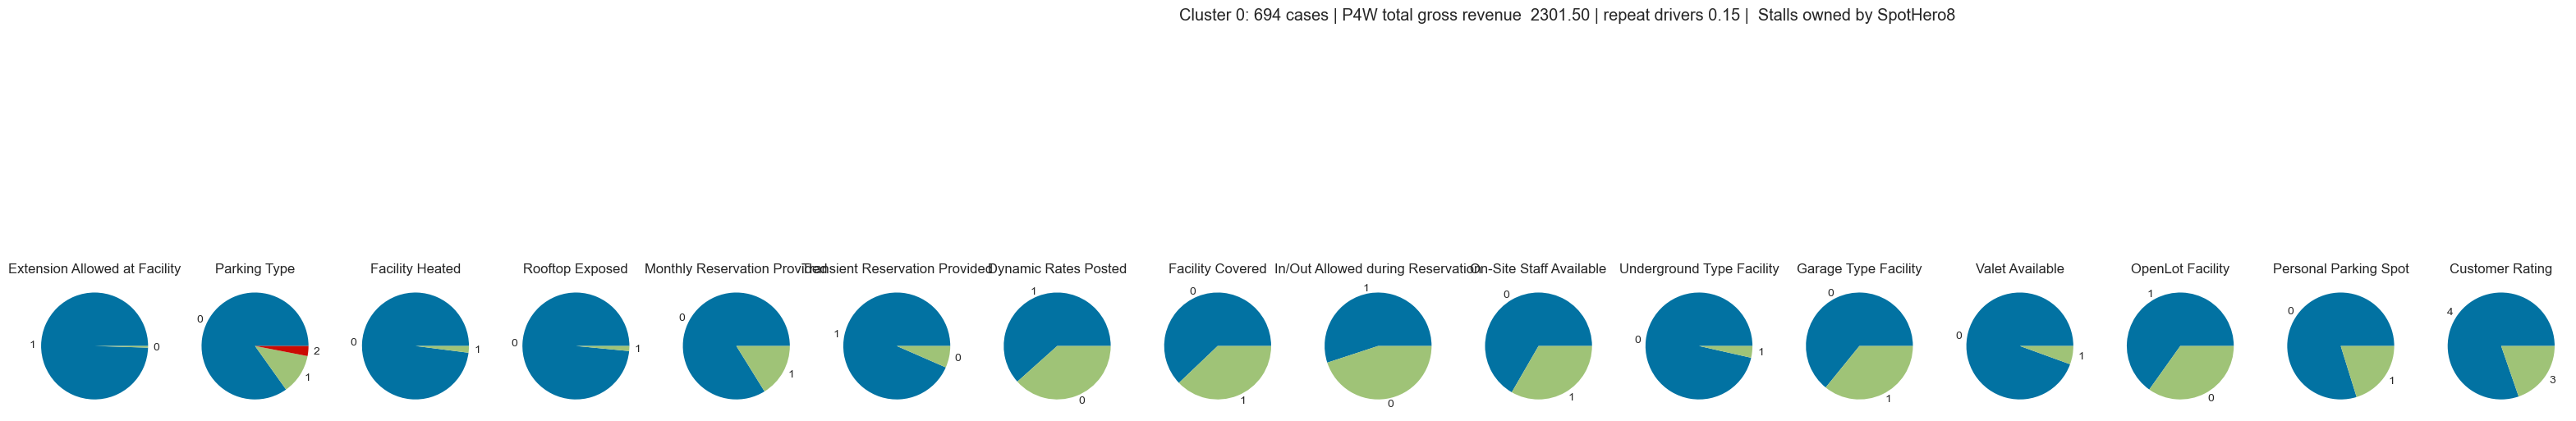

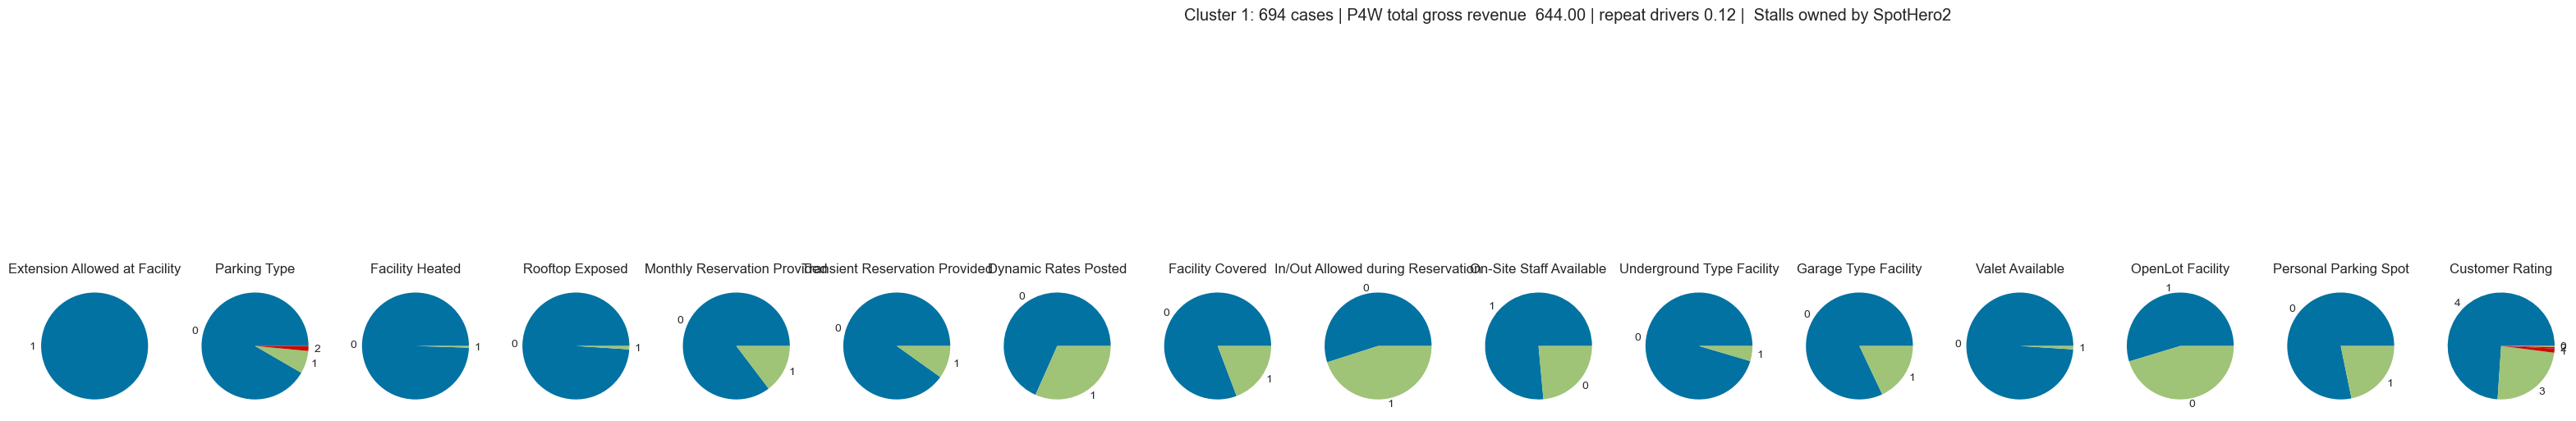

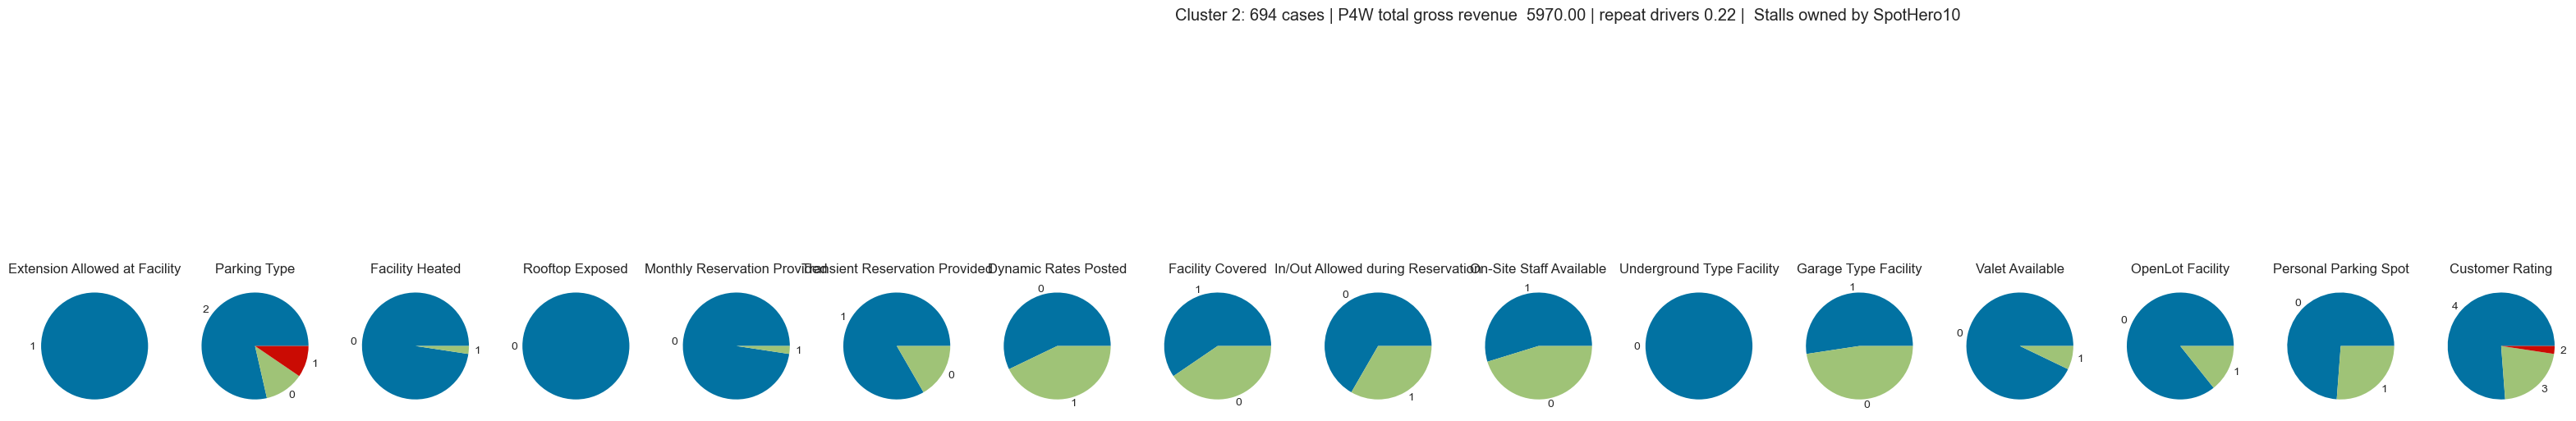

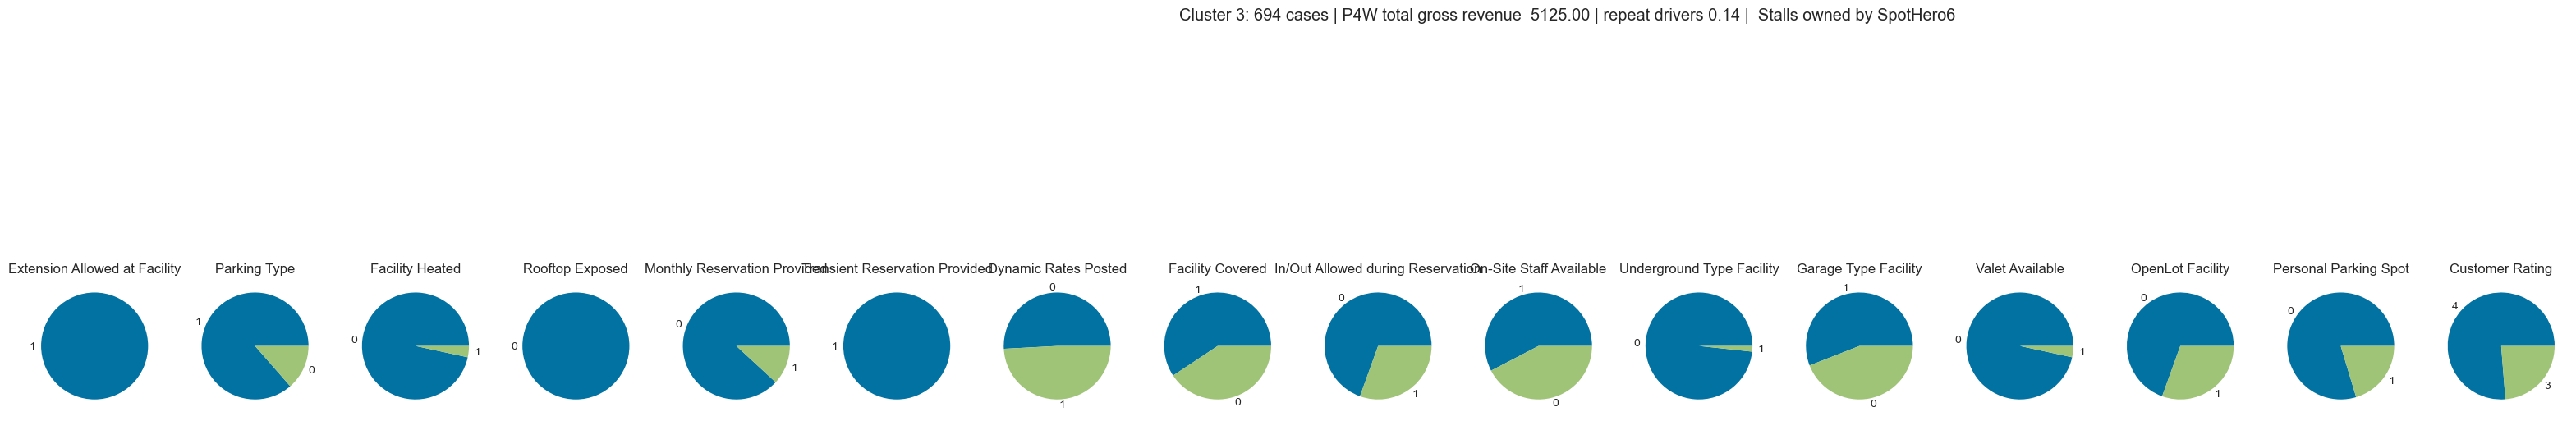

In [32]:
cluster_pies(df)

The pie charts above help to understand the composition of every cluster. Each row of pies represents core properties for a single cluster: Facilities in Cluster 2 are highest revenue generating, SpotHero can increase number of stalls for facilities lying in Cluster 2.


In [34]:
cluster_profile_df = cluster_profile(df)

In [36]:

'''
This method returns a sorted dataframe with ranks of clusters. This is done on bases of seven columns
'p4w_total_gross_revenue','rental_count','p4w_new_drivers', 
                         'p4w_return_pct', 'searches', 'utilization', 'num_stalls' to see which cluster is best. 
'''
def get_ranks_of_cluster(df):
    cluster_profile_df = cluster_profile(df).T
#     print(cluster_profile_df)
    num_clusters = len(cluster_profile_df.columns)
    rank_dic = {i: 0 for i in range(num_clusters)}
    deciding_features = ['p4w_total_gross_revenue','rental_count','p4w_new_drivers', 
                         'p4w_return_pct', 'searches', 'utilization', 'num_stalls']
    for feature in deciding_features:
        cluster = cluster_profile_df.loc[feature].idxmax()
        rank_dic[cluster]+=1
    rank_df = pd.DataFrame.from_dict({'Cluster': rank_dic.keys(), 'Rank': rank_dic.values()})
    rank_df.sort_values(by = 'Rank', inplace=True, ascending =False)
    return rank_df

ranked_clusters_df = get_ranks_of_cluster(df)

In [37]:
'''
Assign qualities to the facilities
'''
def set_qualities_to_facilites(df, ranked_clusters_df):
    ranked_dict = ranked_clusters_df.set_index('Cluster').to_dict()['Rank']
    df['Quality_Score'] = df['Cluster'].map(ranked_dict)
    qualities = df['Quality_Score'].unique()
    
    quality_dict = {max(qualities): 'Best', min(qualities): 'Poor'}
    
    if len(qualities) != len(quality_dict):
        for quality in qualities:
           
            if quality not in quality_dict.keys():
             
                quality_dict[quality] = 'Average'
    df['Quality'] = df['Quality_Score'].map(quality_dict)
    df.drop(columns= 'Quality_Score', inplace=True)
    
set_qualities_to_facilites(df,ranked_clusters_df)
print('.......Qualities Assigned to the clusters')

.......Qualities Assigned to the clusters


In [38]:
'''
Function to get high and low quality clusters
'''
def get_high_and_low_quality_clusters(ranked_clusters_df):
    low_quality_clusters = ranked_clusters_df[ranked_clusters_df.Rank.isin([0,1,2])]['Cluster'].to_list()
    highest_quality_cluster = ranked_clusters_df.reset_index().loc[0]['Cluster']
    return low_quality_clusters, highest_quality_cluster

'''# Helper function'''
def get_diff_cols_row_by_row(row1,row2):
    # row1 should be of lower quality whose features are to be drawn
    # row2 should be of higher quality
    different_col = [col for col in row1.keys() if (row1[col]!=row2[col])]
    return different_col

'''# Helper function'''
# This method takes index of low_quality_cluster and high quality cluster. 
# It returns dictionary with keys as features responsible for lower quality and values as the ideal one 
def get_columns_diff_intra_cluster(cluster_profile_df, highest_quality_cluster, low_quality_cluster ):
    # Categorical columns to be considered
    cat_col_to_consider = list(set(cluster_profile_df.T.reset_index()['index']).intersection(set(CATEGORICAL_COLUMNS)))
    
    
    # Dataframe for comparison of values of categorical columns
    cluster_comparison =cluster_profile_df.T[[low_quality_cluster,highest_quality_cluster]].T
    
    # Converting each column in cluster_comparison as dictionary
    row1 = cluster_comparison[cat_col_to_consider].loc[low_quality_cluster].to_dict()
    row2 = cluster_comparison[cat_col_to_consider].loc[highest_quality_cluster].to_dict()
    
    # Fetching columns that differ in values of rows
    different_col=get_diff_cols_row_by_row(row1, row2)
    
    # Fetch their corresponding calues and return it as output
    different_values ={col: row2[col] for col in different_col}
    return different_values


def fill_features_for_facilities_to_be_improvised(df,cluster_profile_df ,ranked_clusters_df):
    
    low_quality_clusters, highest_quality_cluster = get_high_and_low_quality_clusters(ranked_clusters_df)
    features = []
    for row in df.iterrows():
        cluster = row[1]['Cluster']
        if cluster in low_quality_clusters:
            low_quality_cluster = cluster

            # Dataframe for comparison of values of categorical columns
            cluster_comparison =cluster_profile_df.T[[low_quality_cluster,highest_quality_cluster]]
            different_col_values = get_columns_diff_intra_cluster(cluster_profile_df,highest_quality_cluster,
                                                                  low_quality_cluster)
            row1  = {col: row[1][col] for col in CATEGORICAL_COLUMNS }
            different_col = get_diff_cols_row_by_row(different_col_values, row1)
            if different_col == []:
            
                features.append(get_diff_cols_row_by_row(row1, cluster_comparison.T[CATEGORICAL_COLUMNS].loc[highest_quality_cluster].to_dict()))
            else:
                
                features.append(different_col)
        else:
            features.append('No Need')
    df['Features_affecting'] = features
    
    return df[['facility_id', 'Quality', 'Features_affecting']]

In [39]:
#Fill features to the facilities that need to be improvised
df = fill_features_for_facilities_to_be_improvised(df, cluster_profile_df, ranked_clusters_df)
print('.......Filled affecting features')

.......Filled affecting features


In [40]:
df.head()

,facility_id,Quality,Features_affecting
346,347,Poor,"[has_event_rates, facility_type_garage, covere..."
154,155,Poor,"[facility_type_garage, covered_parking]"
155,156,Poor,"[has_event_rates, facility_type_garage, covere..."
156,157,Poor,"[accessible, iq_facility]"
158,159,Poor,"[facility_type_garage, covered_parking, on_sit..."


In [547]:
df.to_excel('Final_results.xlsx')